# Промежуточное моделирование для Модели микроуровневого стресс-тестирования (на уровне отдельных компаний-застройщиков) - "Банкротства застройщиков"

**В этом блокноте данные для конечной модели банкротств не экстраполируются от приростов медианых значений показателей, а моделируются кластерными моделями**

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from os import path, getcwd
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import sqlalchemy as sa
import statsmodels.api as sm
import matplotlib.pyplot as plt
import patsy
import datetime as dt

# общие константы и функции
idx=pd.IndexSlice # объект для индексации мультииндексного фрейма
strDB_path=path.join('..', 'DB', 'bankrp.sqlite3')
strDB_YEAR_path=path.join('..', 'DB', 'year.sqlite3')

# константы базы данных SQLite3
strSPARK_table='spark' # название таблицы SPARK в базе данных SQLite
strSPARK_agg='spark_ag' # название рабочего  представления для таблицы SPARK в базе данных SQLite (ROA из базы)
strSPARK_agg_roa_calc='spark_ag_roa_calc' # название рабочего  представления для таблицы SPARK (ROA считаем)
strSPARK_data_pass='spark_columns' # таблица с названиями колонок для таблицы SPARK
strLOAN_table='loan' # название таблицы LOAN в базе данных SQLite
strLOAN_data_pass='loan_columns' # таблица с названиями колонок для таблицы loan
strLOAN_agg='loan_agg' # название рабочего  представления для таблицы LOAN в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strBNKRPT_table='bankrp' # название таблицы с фактическими банкротствами
strModeLDATA_table='model_data_fork'  # название таблицы с входными данными для основной модели "Банкротства застройщиков"
# ------------

# пути и константы для данных из Excel-версии модели и базы данных
strModelSource=path.join('..', 'DB', 'SRC', 'Долгосрочная модель.xlsx')
strMargaSheet='Новостройки'
strModelSheet='Модель'
strStrojKomplex='Стройкомплекс'
#---------------

strMD='''
<div class="alert alert-block alert-success">
<b>База данных - {bd_path}<br>
<a href="{bankrupt_prob_DB}?DATABASE={bd_path}" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>
'''.format(bankrupt_prob_DB='bankrupt_prob_DB.ipynb', bd_path=strDB_path)
md(strMD)


<div class="alert alert-block alert-success">
<b>База данных - ../DB/bankrp.sqlite3<br>
<a href="bankrupt_prob_DB.ipynb?DATABASE=../DB/bankrp.sqlite3" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>


## Подготовка данных

 
  1. **Чтение данных из базы данных (таблицы SPARK, NOZA, LOAN и BANKRP).** Данные читаются посредством запросов, созданных на этапе созднания базы данных. Первичный счет показателей осуществляется в этих запросах. При желании можно загрузить данные непосредственно из таблиц, для этого надо поменять название таблицы в строке запроса, в коде, в данном блокноте. Однако вычисления на стороне базы данных несколько быстрее, чем вычисления в коде.   
  2. **Чтение данных из "Долгосрочной модели".** Эти данные предполагается в будущем моделировать в Питоне, однако в настоящий момент они берутся из модели в файле Excel. Эти данные необходимы для построения и расчета промежуточных под-моделей, используемых в основном блоке расчета модели банкротств  
  3. **Построение и расчет промежуточных под-моделей**. Под-модели используются в качестве поставщиков данных для основной модели
  4. **На основе данных промежуточного моделирования формируем таблицу с исходными данными для основной модели и сохраняем ее в базе данных**

### Чтение данных из базы

Данные из таблицы SPARK читаются запросом spark_ag. В запросе расчитывается показатель Z_A: 
`модуль((Кредиторская задолженность - Дебиторская задолженность) / Активы всего)`.

Показатель ROA берется из базы данных, одноко он так же может расчитываться по формуле `Чистая прибыль/Активы всего` (для этого надо использовать запрос spark_ag_roa_calc)


Данные из таблицы LOAN читаются запросом loan_agg. Расчеты выполняются в блокноте.


Данные из таблицы BANKRP читаются полностью. В блокноте выбираются только ИНН, существующие в таблице SPARK.

In [2]:
strSELECT_spark='select * from {spark_table}'.format(spark_table=strSPARK_agg)
strSELECT_LOAN='select * from {loan_table}'.format(loan_table=strLOAN_agg)
strSELECT_Y='select * from {bnkrpt_table}'.format(bnkrpt_table=strBNKRPT_table)

conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_path)) # connection к рабочей базе данных


In [3]:
pdfSPARK=pd.read_sql(strSELECT_spark, con=conWork)
pdfSPARK.replace({None:np.nan}, inplace=True)
pdfSPARK['Cancel_date']=pd.to_datetime(pdfSPARK['Cancel_date'])
print(pdfSPARK.shape)
pdfSPARK.head()

(103968, 6)


,inn,year,capital,Cancel_date,ROA,Z_A
0,3906245291,2013,NaN,NaT,NaN,NaN
1,3801132195,2013,NaN,NaT,NaN,NaN
2,5050102110,2013,10000.0,NaT,NaN,0.633592
3,7448046410,2013,NaN,NaT,NaN,NaN
4,1840032987,2013,NaN,NaT,NaN,NaN


в таблице loan считаем среднюю ставку за год 

In [4]:
pdfLOAN=pd.read_sql(strSELECT_LOAN, con=conWork)

pdfLOAN['date']=pd.to_datetime(pdfLOAN['date'], format='%Y-%m-%d')
pdfLOAN.set_index('date').groupby(by=pd.Grouper(freq='Y'))['loan_nonfin'].mean()

date
2014-12-31    11.135000
2015-12-31    15.716667
2016-12-31    12.592500
2017-12-31    10.560000
2018-12-31     8.866667
2019-12-31     8.753333
2020-12-31     7.554000
Freq: A-DEC, Name: loan_nonfin, dtype: float64

читаем данные фактических банкротств (для всех компаний), выбираем из них только те компании, inn которых есть в базе SPARK

In [5]:
pdf_bnkrpt=pd.read_sql(strSELECT_Y, con=conWork)
pdf_bnkrpt=pdf_bnkrpt.loc[pdf_bnkrpt['inn'].isin(pdfSPARK['inn'].unique())].set_index(['inn', 'year'])
pdf_bnkrpt

,,Y
inn,year,
1001178052,2019,1
1001197513,2020,1
1001224929,2018,1
1001253969,2018,1
1001278882,2020,1
...,...,...
8911001194,2016,1
8911017557,2020,1
9201013503,2018,1


## Загрузка данных из долгосрочной модели


<div class="alert alert-block alert-info">
    Фактические даные - из базы данных с годовыми рядами - распологается локально, файл ./DB/year.sqlite3<br>
    Прогнозные данные - excel-файл с долгосрочной моделью - располагается локально, в каталоге ./DB/SRC<br>
    Чтобы использовать последнюю версию модели сохранить  файл с моделью с расширением xlsx и загрузить его по этому пути
</div>

Эти данные используются для расчета под-моделей: моделирования средней по отрасли рентабельности застройщиков и ...

Читаем:  
   - Изменение среднесписочной численности работников (лист Модель, строка 493; или лист Стройкомплекс, строка 13; фактические данные из year.sqlite3, код 69)
   - Индекс физобъема выпуска (лист Модель, строка 489; или лист Стройкомплекс, строка 6; фактические данные из year.sqlite3, код 65))
   - Маржа прибыли застройщиков (лист Новостройки, строка 10)
   - Индексы номинальных цен на рынке жилья, на вторичном рынке (лист Модель, строка 687, делить на 100; фактические данные из year.sqlite3, код 116))
   
### Читаем фактические данные из базы данных

In [6]:
lst_work_columns=['I_phyvol_issue', 'Chng_avrg_num_empls', 'I_nom_prices_sec_market', 'marga']

strSQL_year_SELECT='select * from datas where code in (65, 69, 116, 131, 52)'

strDB_YEAR_path

conYear = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_YEAR_path))

pdfYear=pd.read_sql(strSQL_year_SELECT, con=conYear).set_index(['date', 'code']).unstack(level=1)

# pdfYear.columns=['I_phyvol_issue', 'Chng_avrg_num_empls', 'I_nom_prices_sec_market']
pdfYear.rename(columns={65:'I_phyvol_issue', 69:'Chng_avrg_num_empls', 116:'I_nom_prices_sec_market', 
                       52:'цена ДДУ', 131:'стоимость строительства жилья'}, 
              inplace=True)

pdfYear.columns=[cn[1] for cn in pdfYear.columns]

pdfYear['marga']=pdfYear['стоимость строительства жилья']/pdfYear['цена ДДУ']
pdfYear=pdfYear[lst_work_columns]
pdfYear.index=pdfYear.index.astype(int)
pdfYear

,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,marga
date,,,,
2004,1.101,NaN,NaN,1.493010
2005,1.132,NaN,NaN,1.531764
2006,1.181,NaN,1.3684,1.663389
2007,1.182,1.029933,1.3389,1.884944
2008,1.128,1.064991,1.1954,1.716113
2009,0.868,0.923699,0.9455,1.434751
2010,1.050,0.960931,0.9843,1.343579
2011,1.051,1.007171,1.0827,1.137379
2012,1.025,1.016925,1.1524,1.210883


### Читаем прогнозные данные из файла Excel (долгосрочная модель)

<div class="alert alert-block alert-info">
    <b>Выполнение следующей ячейки занимает много времени</b>
</div>

In [7]:
# для чтения данных из листа Модель
pdfXLS_model=pd.read_excel(strModelSource, sheet_name=strModelSheet, usecols='B, G:AZ', 
                           skiprows=[i for i in range(1500) if i not in [2, 686, 492, 488]], index_col=0)
pdfXLS_model=pdfXLS_model.T
print('Прочитано из файла ексель', pdfXLS_model.shape)
# print(pdfXLS_model.head())
#==========================
# для чтения данных из листа Стройкомплекс
# pdfXLS_strojK=pd.read_excel(strModelSource, sheet_name=strStrojKomplex, usecols='A, F:BZ', 
#                            skiprows=[i for i in range(1500) if i not in [1, 5, 12]], index_col=0)

# pdfXLS_model=pdfXLS_strojK.T
# print(pdfXLS_model)
# #=========================================

print('Прочитано из файла ексель', pdfXLS_model.shape)


print('Читаем маржу из листа Новостройки, добавляем во фрейм', end='...')
pdfXLS_model['marga']=pd.read_excel(strModelSource, sheet_name=strMargaSheet, usecols='B, K:AZ',
                      skiprows=[i for i in range(255) if i not in [0, 9, 10]], 
                      index_col=0).loc['маржа прибыли застройщиков'] / 100
print('сделано - ', pdfXLS_model.shape)
print('Переименовывыние колонок для удоства использования', end='...')
pdfXLS_model.columns=lst_work_columns

print('сделано')
pdfXLS_model=pdfXLS_model.dropna(how='all')
pdfXLS_model.index=pdfXLS_model.index.astype(int)
pdfXLS_model

Прочитано из файла ексель (28, 3)
Прочитано из файла ексель (28, 3)
Читаем маржу из листа Новостройки, добавляем во фрейм...сделано -  (28, 4)
Переименовывыние колонок для удоства использования...сделано


,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,marga
2009,NaN,NaN,0.945500,1.434751
2010,1.050000,0.960931,0.984300,1.343579
2011,1.051000,1.007171,1.082700,1.137379
2012,1.025000,1.016925,1.152400,1.210883
2013,1.001000,0.987682,1.078200,1.210797
2014,0.977000,0.978279,1.062000,1.148896
2015,0.961000,0.960882,0.987700,1.179112
2016,0.979000,0.973983,0.958900,1.164349
2017,0.989000,0.973601,0.976600,1.214532
2018,1.063000,0.992443,1.015800,1.299932


### Объединение фактических и прогнозных (из долгосрочной модели) значений

In [8]:
pdfXLS_model=pdfXLS_model.append(pdfYear).reset_index().drop_duplicates('index', keep='last').sort_values('index').rename(columns={'index':'year'}).set_index('year')[lst_work_columns]
pdfXLS_model.head()

,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,marga
year,,,,
2004,1.101,NaN,NaN,1.493010
2005,1.132,NaN,NaN,1.531764
2006,1.181,NaN,1.3684,1.663389
2007,1.182,1.029933,1.3389,1.884944
2008,1.128,1.064991,1.1954,1.716113


# Построение и расчет промежуточных моделей

## Подготовка данных для моделирования

<div class="alert alert-block alert-info">
    <b>
    X - предикторы фактических значений<br>
    x - предикторы прогнозных значений<br>
    Y - известные объясняемые значения<br>
    y - прогнозные объясняемые значения<br>
    </b>
</div>
    
Создаем рабочий фрейм данных. Для этого объединяем базу данных SPARK с данными долгосрочной модели. Поле `capital` растягиваем на весь период для каждой компании.  

   `pdfSubModResult` - датафрейм с результатами расчета под-моделей

In [9]:
pdf_sp=pdfSPARK[['inn', 'year', 'capital', 'ROA', 'Z_A']].set_index(['inn', 'year']).dropna(how='all').copy()
pdf_dm=pdfXLS_model.dropna().copy()

print(pdf_sp.head())
print(pdf_dm.head())

                 capital     ROA       Z_A
inn        year                           
5050102110 2013  10000.0     NaN  0.633592
4726000223 2013      NaN -0.0001  0.600232
6154572922 2013      NaN -0.0461       NaN
7701651356 2013  50000.0  0.0256  0.226939
2901112948 2013  10000.0 -0.0004  0.356248
      I_phyvol_issue  Chng_avrg_num_empls  I_nom_prices_sec_market     marga
year                                                                        
2007           1.182             1.029933                   1.3389  1.884944
2008           1.128             1.064991                   1.1954  1.716113
2009           0.868             0.923699                   0.9455  1.434751
2010           1.050             0.960931                   0.9843  1.343579
2011           1.051             1.007171                   1.0827  1.137379


In [10]:
i_new=[ (c, i) for c in pdf_sp.columns for i in pdf_dm.index]
pdf_sp=pdf_sp.unstack().reindex(columns=i_new).stack(dropna=False).join(pdf_dm, how='outer')
pdf_sp

ROA  Z_A  capital  I_phyvol_issue  Chng_avrg_num_empls  \
inn        year                                                           
5050102110 2007  NaN  NaN      NaN        1.182000             1.029933   
           2008  NaN  NaN      NaN        1.128000             1.064991   
           2009  NaN  NaN      NaN        0.868000             0.923699   
           2010  NaN  NaN      NaN        1.050000             0.960931   
           2011  NaN  NaN      NaN        1.051000             1.007171   
...              ...  ...      ...             ...                  ...   
0608024615 2021  NaN  NaN      NaN        1.046579             0.999686   
           2022  NaN  NaN      NaN        1.047423             1.001539   
           2023  NaN  NaN      NaN        1.048266             1.001121   
           2024  NaN  NaN      NaN        1.048266             1.001121   
           2025  NaN  NaN      NaN        1.043736             0.999423   

                 I_nom_prices_sec_market     marga  
inn        year                                     
5050102110 2007                 1.338900  1.884944  
           2008                 1.195400  1.716113  
           2009                 0.945500  1.434751  
           2010                 0.984300  1.343579  
           2011                 1.082700  1.137379  
...                                  ...       ...  
0608024615 2021                 1.200469  1.827218  
           2022                 1.051037  1.842029  
           2023                 1.078206  2.063992  
           2024                 1.032997  1.974492  
           2025                 1.025162  2.016496  

[161500 rows x 7 columns]

In [11]:
ppp=pdf_sp.unstack().loc[idx[:], idx['capital', :]].bfill(axis=1).ffill(axis=1).dropna(how='all').stack(dropna=False)

pdf_sp['capital']=ppp
pdf_sp=pdf_sp.loc[idx[ppp.index.get_level_values(0).unique()]]

pdf_sp

ROA  Z_A  capital  I_phyvol_issue  Chng_avrg_num_empls  \
inn        year                                                           
0104014512 2007  NaN  NaN  10000.0        1.182000             1.029933   
           2008  NaN  NaN  10000.0        1.128000             1.064991   
           2009  NaN  NaN  10000.0        0.868000             0.923699   
           2010  NaN  NaN  10000.0        1.050000             0.960931   
           2011  NaN  NaN  10000.0        1.051000             1.007171   
...              ...  ...      ...             ...                  ...   
9731012872 2021  NaN  NaN  10000.0        1.046579             0.999686   
           2022  NaN  NaN  10000.0        1.047423             1.001539   
           2023  NaN  NaN  10000.0        1.048266             1.001121   
           2024  NaN  NaN  10000.0        1.048266             1.001121   
           2025  NaN  NaN  10000.0        1.043736             0.999423   

                 I_nom_prices_sec_market     marga  
inn        year                                     
0104014512 2007                 1.338900  1.884944  
           2008                 1.195400  1.716113  
           2009                 0.945500  1.434751  
           2010                 0.984300  1.343579  
           2011                 1.082700  1.137379  
...                                  ...       ...  
9731012872 2021                 1.200469  1.827218  
           2022                 1.051037  1.842029  
           2023                 1.078206  2.063992  
           2024                 1.032997  1.974492  
           2025                 1.025162  2.016496  

[149720 rows x 7 columns]

## Промежуточное моделирование

### Модель *Рентабельность застройщиков (ROA)*

Модель кластерная, с группировкой по `inn` - по компаниям  
<br>
<center>${ROA}$ ~ $I\_nom\_prices\_sec\_market$ + $marga$ + $1$</center>

<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Индексы номинальных цен на рынке жилья, на вторичном рынке (<i>I_nom_prices_sec_market</i>, из данных Долгосрочной модели)</li>
        <li>Маржа прибыли застройщиков (<i>marga</i>, из данных Долгосрочной модели)</li>        
    </ul><br>
    <b>Объясняемая переменная</b> - медианная по отрасли рентабельность застройщика (<i>ROA</i> датафрейма <i>pdfSPARK</i>)
</div>

In [12]:
iYearFact=pdfSPARK['year'].max()

_pdf_XY=pdf_sp.loc[idx[:, :iYearFact+1], :].dropna().reset_index()
_pdf_xy=pdf_sp.loc[idx[:, iYearFact+1:], :].reset_index()

model_roa = sm.GEE.from_formula(formula = "ROA ~ I_nom_prices_sec_market + marga + 1",
groups="inn", cov_struct=sm.cov_struct.Exchangeable(), data=_pdf_XY).fit() #, family=sm.families.Gamma()
# # Autoregressive Exchangeable , family=sm.families.Gaussian()
print(model_roa.summary())

                               GEE Regression Results                              
Dep. Variable:                         ROA   No. Observations:                44010
Model:                                 GEE   No. clusters:                     7588
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  12
Family:                           Gaussian   Mean cluster size:                 5.8
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Thu, 17 Sep 2020   Scale:                           5.977
Covariance type:                    robust   Time:                         19:24:27
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.3234      0.221     -1.464    

In [13]:
_pdf_xy['ROA_mod'] = model_roa.predict(_pdf_xy)

pdf_sp['ROA_mod']=np.nan
pdf_sp['ROA_mod']=_pdf_xy.set_index(['inn', 'year'])['ROA_mod']
pdf_sp['ROA_mod']=pdf_sp['ROA_mod'].combine_first(pdf_sp['ROA'])
pdf_sp.loc[idx[:, 2018:], :]

ROA       Z_A     capital  I_phyvol_issue  \
inn        year                                                 
0104014512 2018  0.0011  0.178391  40000000.0        1.063000   
           2019  0.0006  0.082383   2495000.0        1.006000   
           2020     NaN       NaN   2495000.0        0.910849   
           2021     NaN       NaN   2495000.0        1.046579   
           2022     NaN       NaN   2495000.0        1.047423   
...                 ...       ...         ...             ...   
9731012872 2021     NaN       NaN     10000.0        1.046579   
           2022     NaN       NaN     10000.0        1.047423   
           2023     NaN       NaN     10000.0        1.048266   
           2024     NaN       NaN     10000.0        1.048266   
           2025     NaN       NaN     10000.0        1.043736   

                 Chng_avrg_num_empls  I_nom_prices_sec_market     marga  \
inn        year                                                           
0104014512 2018             0.992443                 1.015800  1.299932   
           2019             1.070656                 1.043100  1.316426   
           2020             0.945160                 1.023019  1.451248   
           2021             0.999686                 1.200469  1.827218   
           2022             1.001539                 1.051037  1.842029   
...                              ...                      ...       ...   
9731012872 2021             0.999686                 1.200469  1.827218   
           2022             1.001539                 1.051037  1.842029   
           2023             1.001121                 1.078206  2.063992   
           2024             1.001121                 1.032997  1.974492   
           2025             0.999423                 1.025162  2.016496   

                  ROA_mod  
inn        year            
0104014512 2018  0.001100  
           2019  0.000600  
           2020 -0.016532  
           2021  0.042677  
           2022  0.008756  
...                   ...  
9731012872 2021  0.042677  
           2022  0.008756  
           2023  0.025728  
           2024  0.010945  
           2025  0.011149  

[63040 rows x 8 columns]

<AxesSubplot:xlabel='year'>

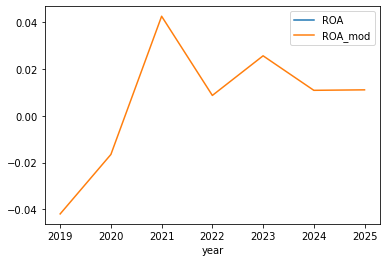

In [14]:
# pdf_sp['roa_pred']=model_roa.predict()
pdf_sp.loc[idx['1660063094', :], idx['ROA', 'ROA_mod']].droplevel(level=0).plot.line()

### Модель *Чистая кредиторская задолженность (Z_A)*

Модель кластерная, с группировкой по `inn` - по компаниям  
<br>

<center>$Z\_A$ ~ $I\_phyvol\_issue_{y-1} + Chng\_avrg\_num\_empls_{y-1} + 1$</center>

<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Индекс физобъема выпуска (<i>I_phyvol_issue</i>, из данных Долгосрочной модели, с лагом 1 год)</li>
        <li>Изменение среднесписочной численности работников (<i>Chng_avrg_num_empls</i>, из данных Долгосрочной модели, с лагом 1 год))</li>        
    </ul><br>
    <b>Объясняемая переменная</b> - Чистая кредиторская задолженность rjvgfybb(Z_A датафрейма pdfSPARK)
</div>

In [17]:
model_za = sm.GEE.from_formula(formula = "Z_A ~ I_phyvol_issue.shift(1) + Chng_avrg_num_empls.shift(1) + 1",
groups="inn", cov_struct=sm.cov_struct.Exchangeable(), data=_pdf_XY).fit()
# # Autoregressive Exchangeable , family=sm.families.Gaussian()
print(model_za.summary())

                               GEE Regression Results                              
Dep. Variable:                         Z_A   No. Observations:                44009
Model:                                 GEE   No. clusters:                     7588
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  12
Family:                           Gaussian   Mean cluster size:                 5.8
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Thu, 17 Sep 2020   Scale:                         448.756
Covariance type:                    robust   Time:                         14:47:10
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -4.7395      4.537

In [18]:
_pdf_xy

,inn,year,ROA,Z_A,capital,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,marga,ROA_mod
0,0104014512,2020,NaN,NaN,2495000.0,0.910849,0.945160,1.023019,1.451248,-0.016532
1,0104014512,2021,NaN,NaN,2495000.0,1.046579,0.999686,1.200469,1.827218,0.042677
2,0104014512,2022,NaN,NaN,2495000.0,1.047423,1.001539,1.051037,1.842029,0.008756
3,0104014512,2023,NaN,NaN,2495000.0,1.048266,1.001121,1.078206,2.063992,0.025728
4,0104014512,2024,NaN,NaN,2495000.0,1.048266,1.001121,1.032997,1.974492,0.010945
...,...,...,...,...,...,...,...,...,...,...
47275,9731012872,2021,NaN,NaN,10000.0,1.046579,0.999686,1.200469,1.827218,0.042677
47276,9731012872,2022,NaN,NaN,10000.0,1.047423,1.001539,1.051037,1.842029,0.008756
47277,9731012872,2023,NaN,NaN,10000.0,1.048266,1.001121,1.078206,2.063992,0.025728
47278,9731012872,2024,NaN,NaN,10000.0,1.048266,1.001121,1.032997,1.974492,0.010945


In [19]:
_pdf_xy['Z_A_mod'] = model_za.predict(_pdf_xy)
pdf_sp['Z_A_mod']=np.nan
pdf_sp['Z_A_mod']=_pdf_xy.set_index(['inn', 'year'])['Z_A_mod']
pdf_sp['Z_A_mod']=pdf_sp['Z_A_mod'].combine_first(pdf_sp['Z_A'])
pdf_sp.loc[idx[:, 2018:], :]

ROA       Z_A     capital  I_phyvol_issue  \
inn        year                                                 
0104014512 2018  0.0011  0.178391  40000000.0        1.063000   
           2019  0.0006  0.082383   2495000.0        1.006000   
           2020     NaN       NaN   2495000.0        0.910849   
           2021     NaN       NaN   2495000.0        1.046579   
           2022     NaN       NaN   2495000.0        1.047423   
...                 ...       ...         ...             ...   
9731012872 2021     NaN       NaN     10000.0        1.046579   
           2022     NaN       NaN     10000.0        1.047423   
           2023     NaN       NaN     10000.0        1.048266   
           2024     NaN       NaN     10000.0        1.048266   
           2025     NaN       NaN     10000.0        1.043736   

                 Chng_avrg_num_empls  I_nom_prices_sec_market     marga  \
inn        year                                                           
0104014512 2018             0.992443                 1.015800  1.299932   
           2019             1.070656                 1.043100  1.316426   
           2020             0.945160                 1.023019  1.451248   
           2021             0.999686                 1.200469  1.827218   
           2022             1.001539                 1.051037  1.842029   
...                              ...                      ...       ...   
9731012872 2021             0.999686                 1.200469  1.827218   
           2022             1.001539                 1.051037  1.842029   
           2023             1.001121                 1.078206  2.063992   
           2024             1.001121                 1.032997  1.974492   
           2025             0.999423                 1.025162  2.016496   

                  ROA_mod   Z_A_mod  
inn        year                      
0104014512 2018  0.001100  0.178391  
           2019  0.000600  0.082383  
           2020 -0.016532       NaN  
           2021  0.042677  0.127682  
           2022  0.008756  1.005492  
...                   ...       ...  
9731012872 2021  0.042677  0.127682  
           2022  0.008756  1.005492  
           2023  0.025728  1.008272  
           2024  0.010945  1.015064  
           2025  0.011149  1.015064  

[63040 rows x 9 columns]

<AxesSubplot:xlabel='year'>

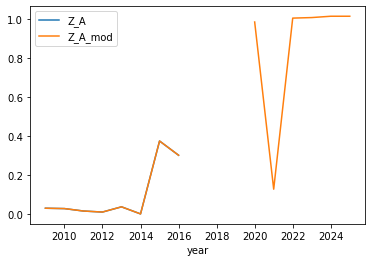

In [20]:
pdf_sp.loc[idx['9731012872', :], idx['Z_A', 'Z_A_mod']].droplevel(level=0).plot.line()

### Модель *Ставка по кредитам*

<div class="alert alert-block alert-danger">
    <b>ЭТОГО ПОКА НЕТ</b>
</div>


<AxesSubplot:xlabel='date'>

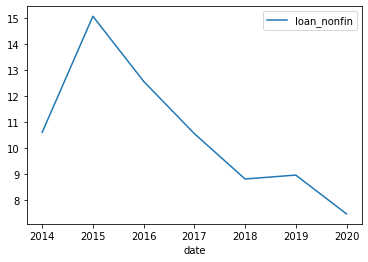

In [21]:
pdf=pdfLOAN.set_index('date').groupby(by=pd.Grouper(freq='Y')).agg(np.median)
pdf.index=pdf.index.year
pdf.plot.line()

## Установка флага фактического банкротства компании. 

"1" в соотв. году означает банкростство даной компании в этом году. Данные последующих лет для этой компании удаляются (ниже).

In [22]:
pdf_sp['Y']=pdf_bnkrpt
pdf_sp['Y'].fillna(0, inplace=True)
pdf_sp

ROA  Z_A  capital  I_phyvol_issue  Chng_avrg_num_empls  \
inn        year                                                           
0104014512 2007  NaN  NaN  10000.0        1.182000             1.029933   
           2008  NaN  NaN  10000.0        1.128000             1.064991   
           2009  NaN  NaN  10000.0        0.868000             0.923699   
           2010  NaN  NaN  10000.0        1.050000             0.960931   
           2011  NaN  NaN  10000.0        1.051000             1.007171   
...              ...  ...      ...             ...                  ...   
9731012872 2021  NaN  NaN  10000.0        1.046579             0.999686   
           2022  NaN  NaN  10000.0        1.047423             1.001539   
           2023  NaN  NaN  10000.0        1.048266             1.001121   
           2024  NaN  NaN  10000.0        1.048266             1.001121   
           2025  NaN  NaN  10000.0        1.043736             0.999423   

                 I_nom_prices_sec_market     marga   ROA_mod   Z_A_mod    Y  
inn        year                                                              
0104014512 2007                 1.338900  1.884944       NaN       NaN  0.0  
           2008                 1.195400  1.716113       NaN       NaN  0.0  
           2009                 0.945500  1.434751       NaN       NaN  0.0  
           2010                 0.984300  1.343579       NaN       NaN  0.0  
           2011                 1.082700  1.137379       NaN       NaN  0.0  
...                                  ...       ...       ...       ...  ...  
9731012872 2021                 1.200469  1.827218  0.042677  0.127682  0.0  
           2022                 1.051037  1.842029  0.008756  1.005492  0.0  
           2023                 1.078206  2.063992  0.025728  1.008272  0.0  
           2024                 1.032997  1.974492  0.010945  1.015064  0.0  
           2025                 1.025162  2.016496  0.011149  1.015064  0.0  

[149720 rows x 10 columns]

## Запись полученного фрейма в базу данных

Таблица `model_data_fork`

Для записи используется стандартный фрейм pandas, таблица перезаписывается полностью - она является результатом обработки, все года пересчитываются.

Рабочие поля таблицы:
  - inn (индексное поле) - ИНН компании
  - year (индексное поле) - год снятия показателя. Годы после объявления компании банкротом отсутствуют
  - ROA_mod - рентабельность, продленная на прогнозный период
  - Z_A_mod - задолженность, продленная на прогнозный период
  - Y - флаг банкротства. "1" стоит в последнем валидном годе компании 

In [23]:
pdf_sp[['Y', 'capital', 'ROA_mod', 'Z_A_mod']].to_sql(strModeLDATA_table, con=conWork, if_exists='replace')

print('Done for', pdf_sp.shape)

Done for (149720, 10)


## Окончание работы - сжатие и очиста базы даных

In [24]:
import sqlite3
conn = sqlite3.connect(strDB_path, isolation_level=None)
conn.execute("VACUUM") # сжатие базы данных
conn.close()

print('All done')

All done


<div class="alert alert-block alert-warning">
    <b>Ниже код для проверок текущего выполнения блокнота, тестирования полученых датафреймов и т.д.</b>
</div>

In [76]:
_pdf['inn'].unique()

array(['0104014512', '0105003792', '0105008695', ..., '9721014302',
       '9729055420', '9731012872'], dtype=object)

In [104]:
pdf_sp.loc[idx[ ['0104014512', '1660063094', '1001178052'], :], idx[:]]

ROA        Z_A     capital  I_phyvol_issue  \
inn        year                                                  
0104014512 2007     NaN        NaN     10000.0        1.182000   
           2008     NaN        NaN     10000.0        1.128000   
           2009     NaN        NaN     10000.0        0.868000   
           2010     NaN        NaN     10000.0        1.050000   
           2011     NaN        NaN     10000.0        1.051000   
           2012     NaN        NaN     10000.0        1.025000   
           2013     NaN        NaN     10000.0        1.001000   
           2014 -0.0426   0.797872     10000.0        0.977000   
           2015  0.0041   0.960739     10000.0        0.961000   
           2016  0.0015   0.255651     10000.0        0.979000   
           2017  0.0523   0.190691  40000000.0        0.989000   
           2018  0.0011   0.178391  40000000.0        1.063000   
           2019  0.0006   0.082383   2495000.0        1.006000   
           2020     NaN        NaN   2495000.0        0.910849   
           2021     NaN        NaN   2495000.0        1.046579   
           2022     NaN        NaN   2495000.0        1.047423   
           2023     NaN        NaN   2495000.0        1.048266   
           2024     NaN        NaN   2495000.0        1.048266   
           2025     NaN        NaN   2495000.0        1.043736   
1660063094 2007     NaN        NaN     20000.0        1.182000   
           2008     NaN        NaN     20000.0        1.128000   
           2009     NaN  12.596491     20000.0        0.868000   
           2010     NaN   0.979238     20000.0        1.050000   
           2011     NaN        NaN     20000.0        1.051000   
           2012     NaN        NaN     20000.0        1.025000   
           2013     NaN        NaN     20000.0        1.001000   
           2014     NaN        NaN     20000.0        0.977000   
           2015     NaN        NaN     20000.0        0.961000   
           2016     NaN        NaN     20000.0        0.979000   
           2017     NaN        NaN     20000.0        0.989000   
           2018     NaN   0.228289     20000.0        1.063000   
           2019 -0.0420   0.173421     20000.0        1.006000   
           2020     NaN        NaN     20000.0        0.910849   
           2021     NaN        NaN     20000.0        1.046579   
           2022     NaN        NaN     20000.0        1.047423   
           2023     NaN        NaN     20000.0        1.048266   
           2024     NaN        NaN     20000.0        1.048266   
           2025     NaN        NaN     20000.0        1.043736   
1001178052 2007     NaN        NaN     10000.0        1.182000   
           2008     NaN        NaN     10000.0        1.128000   
           2009     NaN        NaN     10000.0        0.868000   
           2010     NaN        NaN     10000.0        1.050000   
           2011     NaN        NaN     10000.0        1.051000   
           2012     NaN   0.461356     10000.0        1.025000   
           2013  0.0008   0.262276     10000.0        1.001000   
           2014  0.0040   0.027532     10000.0        0.977000   
           2015  0.0016   0.084550     10000.0        0.961000   
           2016  0.0001   0.295141     10000.0        0.979000   
           2017     NaN   0.108886     10000.0        0.989000   
           2018 -0.0560   0.031194     10000.0        1.063000   
           2019 -0.0044   0.001583     10000.0        1.006000   
           2020     NaN        NaN     10000.0        0.910849   
           2021     NaN        NaN     10000.0        1.046579   
           2022     NaN        NaN     10000.0        1.047423   
           2023     NaN        NaN     10000.0        1.048266   
           2024     NaN        NaN     10000.0        1.048266   
           2025     NaN        NaN     10000.0        1.043736   

                 Chng_avrg_num_empls  I_nom_prices_sec_market     marga  \
inn        year                                   

In [64]:
pdf_sp.loc[idx[ ['0104014512', '1660063094', '1001178052'], :], idx[:]]


Cancel_date     ROA       Z_A     capital      ROA_      Z_A_  \
inn        year                                                                 
0104014512 2009         NaT     NaN       NaN     10000.0  0.003600  0.181202   
           2010         NaT     NaN       NaN     10000.0  0.003100  0.184730   
           2011         NaT     NaN       NaN     10000.0  0.004000  0.174625   
           2012         NaT     NaN       NaN     10000.0  0.003000  0.196358   
           2013         NaT     NaN       NaN     10000.0  0.002200  0.203161   
           2014         NaT -0.0426  0.797872     10000.0  0.001400  0.194526   
           2015         NaT  0.0041  0.960739     10000.0  0.001400  0.191316   
           2016         NaT  0.0015  0.255651     10000.0  0.001100  0.190117   
           2017         NaT  0.0523  0.190691  40000000.0  0.000700  0.185076   
           2018         NaT  0.0011  0.178391  40000000.0  0.000800  0.185689   
           2019         NaT  0.0006  0.082383   2495000.0  0.001100  0.194353   
           2020         NaT     NaN       NaN   2495000.0  0.002941  0.209570   
           2021         NaT     NaN       NaN   2495000.0  0.005940  0.191393   
           2022         NaT     NaN       NaN   2495000.0  0.004892  0.187534   
           2023         NaT     NaN       NaN   2495000.0  0.006084  0.187872   
           2024         NaT     NaN       NaN   2495000.0  0.005348  0.187667   
           2025         NaT     NaN       NaN   2495000.0  0.005477  0.187667   
1001178052 2009         NaT     NaN       NaN     10000.0  0.003600  0.181202   
           2010         NaT     NaN       NaN     10000.0  0.003100  0.184730   
           2011         NaT     NaN       NaN     10000.0  0.004000  0.174625   
           2012         NaT     NaN       NaN     10000.0  0.003000  0.196358   
           2013         NaT  0.0008  0.262276     10000.0  0.002200  0.203161   
           2014         NaT  0.0040  0.027532     10000.0  0.001400  0.194526   
           2015         NaT  0.0016  0.084550     10000.0  0.001400  0.191316   
           2016         NaT  0.0001  0.295141     10000.0  0.001100  0.190117   
           2017         NaT     NaN       NaN     10000.0  0.000700  0.185076   
           2018         NaT -0.0560  0.031194     10000.0  0.000800  0.185689   
           2019         NaT -0.0044  0.001583     10000.0  0.001100  0.194353   

                    ROA_t     Z_A_t     ROA_d     Z_A_d    Y   ROA_par  \
inn        year                                                          
0104014512 2009 -0.327103  0.037419 -0.001750  0.006536  0.0       NaN   
           2010 -0.138889  0.019470 -0.000500  0.003528  0.0       NaN   
           2011  0.290323 -0.054703  0.000900 -0.010105  0.0       NaN   
           2012 -0.250000  0.124454 -0.001000  0.021733  0.0       NaN   
           2013 -0.266667  0.034648 -0.000800  0.006803  0.0       NaN   
           2014 -0.363636 -0.042504 -0.000800 -0.008635  0.0 -0.042600   
           2015  0.000000 -0.016500  0.000000 -0.003210  0.0  0.004100   
           2016 -0.214286 -0.006267 -0.000300 -0.001199  0.0  0.001500   
           2017 -0.363636 -0.026518 -0.000400 -0.005042  0.0  0.052300   
           2018  0.142857  0.003315  0.000100  0.000614  0.0  0.001100   
           2019  0.375000  0.046656  0.000300  0.008663  0.0  0.000600   
           2020  1.674018  0.078294  0.001841  0.015217  0.0  0.002441   
           2021  1.019392 -0.086732  0.002998 -0.018176  0.0  0.005440   
           2022 -0.176394 -0.020164 -0.001048 -0.003859  0.0  0.004392   
           2023  0.243634  0.001804  0.001192  0.000338  0.0  0.005584   
           2024 -0.120958 -0.001092 -0.000736 -0.000205  0.0  0.004848   
           2025  0.024090  0.000000  0.000129  0.000000  0.0  0.004977   
1001178052 2009 -0.327103  0.037419 -0.001750  0.006536  0.0       NaN   
           2010 -0.138889  0.019470 -0.000500  0.003528  0.0       NaN   
           2011  0.290323 -0.05

In [74]:
pdf_bnkrpt.loc[idx['1001178052', :], :]

,,Y
inn,year,
1001178052,2019,1
